In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


Import Libraries

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np

# Load the IMDb dataset
dataset = load_dataset('imdb')

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Apply preprocessing
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Rename columns to match the expected format for Hugging Face
encoded_dataset = encoded_dataset.rename_column("label", "labels")

# Split dataset into training and test sets
train_dataset = encoded_dataset['train']
test_dataset = encoded_dataset['test']

# Define accuracy metric function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean()}

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',             # Evaluate every 'eval_steps' steps
    eval_steps=500,                          # Number of steps between evaluations
    per_device_train_batch_size=8,           # Reduce batch size to speed up training
    per_device_eval_batch_size=8,            # Reduce batch size for evaluation
    num_train_epochs=2,                      # Reduce the number of epochs for faster training
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,                       # Log every 50 steps
    save_steps=500,                         # Save the model every 500 steps
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',       # Use accuracy as the metric for best model
    greater_is_better=True
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # Add the compute_metrics function
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.423900,0.500143,0.817440
1000,0.409900,0.412061,0.835600
1500,0.359100,0.335274,0.853440
2000,0.308500,0.412312,0.850280
2500,0.355600,0.317148,0.864160
3000,0.342800,0.387773,0.869560
3500,0.234000,0.442967,0.869840
4000,0.196600,0.469101,0.871760
4500,0.209600,0.470457,0.871000
5000,0.252200,0.495759,0.877320


{'eval_loss': 0.4957585632801056, 'eval_accuracy': 0.8773199915885925, 'eval_runtime': 93.488, 'eval_samples_per_second': 267.414, 'eval_steps_per_second': 33.427, 'epoch': 2.0}


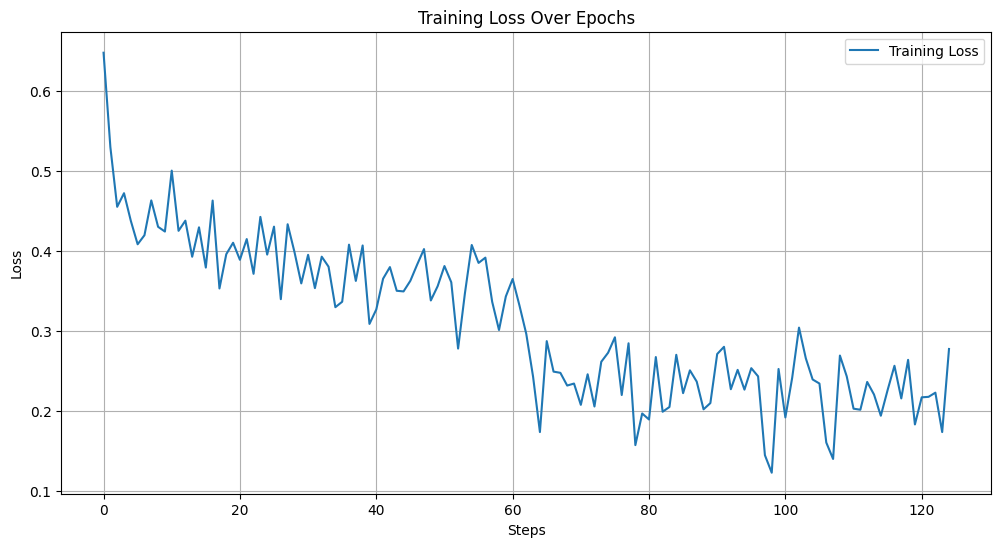

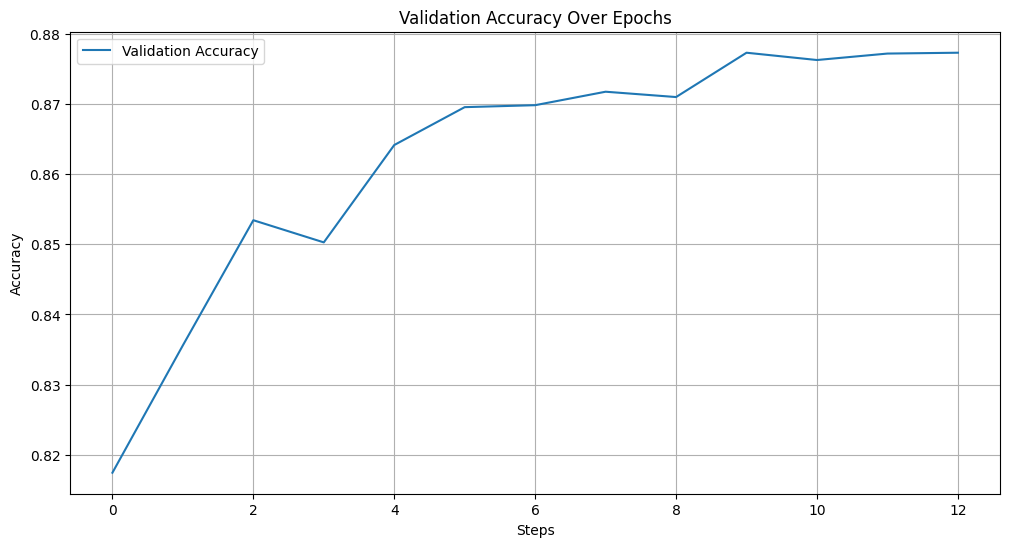

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Add the following to the end of your training script

# Extract logs from the training process
log_history = trainer.state.log_history

# Extract loss and accuracy from logs
def extract_metric(log_history, metric_name):
    return [log[metric_name] for log in log_history if metric_name in log]

# Extract training loss and accuracy
train_loss = extract_metric(log_history, 'loss')
eval_accuracy = extract_metric(log_history, 'eval_accuracy')

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot evaluation accuracy
plt.figure(figsize=(12, 6))
plt.plot(eval_accuracy, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from transformers import pipeline

# Load the pre-trained model without fine-tuning
pretrained_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
pretrained_model.to(device)

# Initialize the pipeline for sentiment analysis
pretrained_pipeline = pipeline('sentiment-analysis', model=pretrained_model, tokenizer=tokenizer)

# Function to evaluate the model
def evaluate_model(pipeline, dataset):
    predictions = []
    labels = []
    for example in dataset:
        inputs = tokenizer(example['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=128).to(device)
        with torch.no_grad():
            outputs = pipeline.model(**inputs)
        predictions.append(np.argmax(outputs.logits.cpu().numpy()))
        labels.append(example['labels'])
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    return accuracy

# Evaluate the pre-trained model
pretrained_accuracy = evaluate_model(pretrained_pipeline, test_dataset)

# Evaluate the fine-tuned model
fine_tuned_accuracy = trainer.evaluate()['eval_accuracy']

# Print results
print(f"Pre-trained model accuracy: {pretrained_accuracy:.4f}")
print(f"Fine-tuned model accuracy: {fine_tuned_accuracy:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Pre-trained model accuracy: 0.4947
Fine-tuned model accuracy: 0.8773
